<h1><center>GLM Final Project</center></h1>

<h3><center>STAT GR5232</center></h3>

<h3><center>May 6th, 2019</center></h3>

<center>Yiding Xie (yx2443)</center>
<center>Zhibo Zhou (zz2520)</center>
<center>Gye Hyun Baek (gb2508)</center>

# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
import time
import xgboost as xgb
import multiprocessing
import sys
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.ensemble import VotingClassifier


# Set up

In [4]:
seed = 2019

num_core = multiprocessing.cpu_count()
print("There are " + str(num_core) + " cores on this machine.")

There are 8 cores on this machine.


# Import Data

In [5]:
df0 = pd.read_csv('/home/glm2class2019/2018_data.csv', low_memory=False)
df0.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,NaN,NaN,30000.0,30000.0,30000.0,36 months,7.34%,930.99,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,34825.0,34825.0,34825.0,60 months,12.61%,785.45,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,2600.0,2600.0,2600.0,36 months,7.96%,81.43,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,20000.0,20000.0,20000.0,60 months,9.92%,424.16,B,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,17000.0,17000.0,17000.0,60 months,20.39%,454.10,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df0.shape

(495250, 146)

# Define function

In [7]:
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

def loan_condition(status):
    if status in bad_loan:
        return 'Bad_Loan'
    else:
        return 'Good_Loan'
    

# Initial Data Check

In [8]:
## Drop 1st column
df0.drop('Unnamed: 0', axis=1, inplace=True)

## Check missing values by percentage
miss_values = null_values(df0)
miss_values.head(15)


Dataframe has 145 columns.
There are 145 columns that have missing values.


,Missing Values,% of Total Values
desc,495250,100.0
url,495250,100.0
member_id,495250,100.0
id,495242,100.0
orig_projected_additional_accrued_interest,495017,100.0
payment_plan_start_date,494980,99.9
hardship_reason,494980,99.9
hardship_status,494980,99.9
deferral_term,494980,99.9
hardship_amount,494980,99.9


In [9]:
ignore_column = miss_values.index.values[miss_values.iloc[:,1] >= 49]

## Drop NA Columns
df0.drop(ignore_column,axis=1,inplace=True)

## Drop NA rows
df0.dropna(subset=['loan_amnt'],axis = 'index',inplace=True)

df0.shape

(495242, 102)

# Define Good and Bad Loans

In [10]:
df0["loan_status"].value_counts()

Current               437318
Fully Paid             40240
Charged Off             6942
Late (31-120 days)      6509
In Grace Period         2901
Late (16-30 days)       1323
Default                    9
Name: loan_status, dtype: int64

In [11]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]

df0['loan_condition'] = np.nan
df0['loan_condition'] = df0['loan_status'].apply(loan_condition)

In [12]:
print(sum(df0['loan_condition']=='Bad_Loan'))  ## Number of Bad Loan
print(sum(df0['loan_condition']!='Bad_Loan'))  ## Number of Good Loan

17684
477558


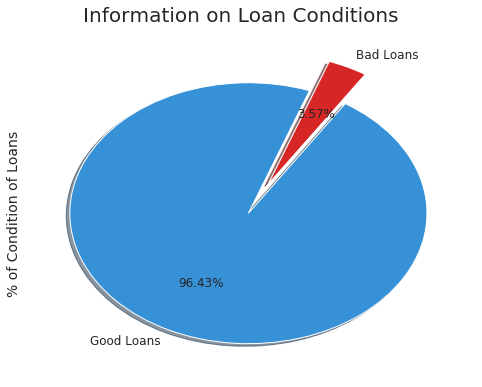

In [13]:
fig = plt.figure(figsize=(8,6))
colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df0["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)

# ax[0].set_title('State of Loan', fontsize=16)
plt.ylabel('% of Condition of Loans', fontsize=14)
plt.show()


# Data Cleaning (1st Clean)

In [14]:
## Convert time variables
df0['issue_d']= pd.to_datetime(df0['issue_d']).apply(lambda x: int(x.strftime('%Y')))
#df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'].fillna('2019-01-01')).apply(lambda x: int(x.strftime('%m')))
#df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'].fillna("2019-01-01")).apply(lambda x: int(x.strftime('%m')))
#df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'].fillna('2001-08-01')).apply(lambda x: int(x.strftime('%m')))

## Convert percentage to float
df0['int_rate'] = df0['int_rate'].str.rstrip('%').astype('float') / 100.0
df0['revol_util'] = df0['revol_util'].str.rstrip('%').astype('float') / 100.0


# EDA

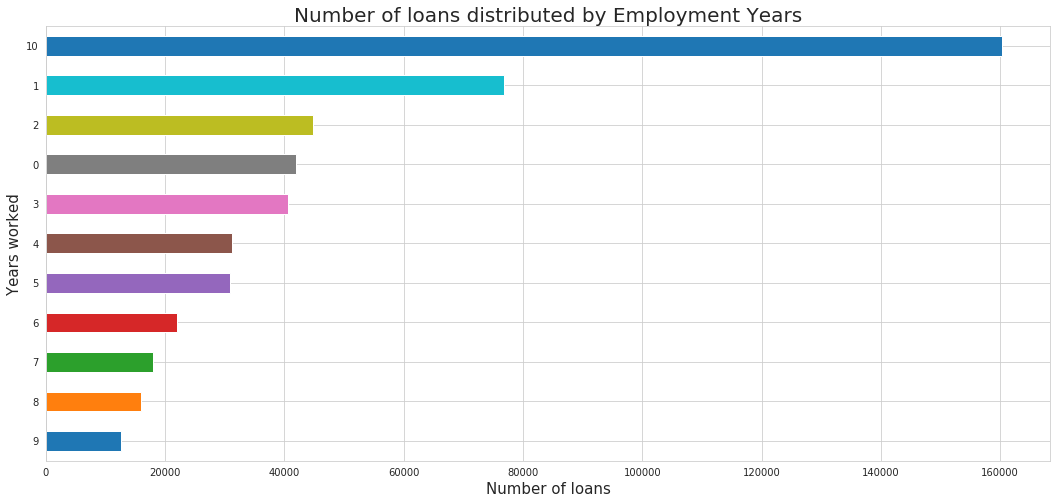

In [9]:
df0['emp_length'].head(5)
df0['emp_length'].fillna(value=0,inplace=True)
df0['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df0['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15)
plt.show()

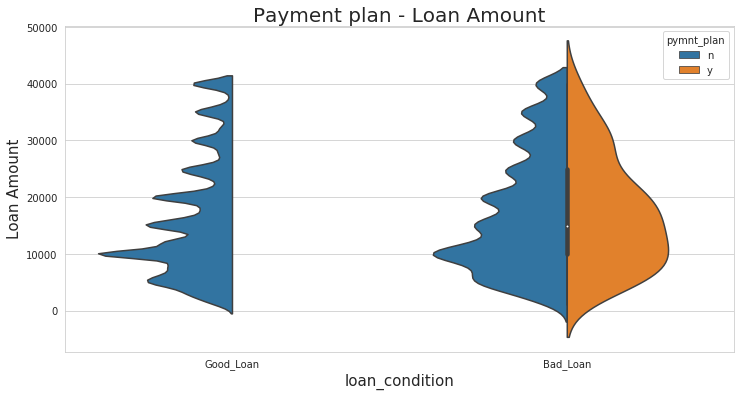

In [10]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="loan_condition",y="loan_amnt",data=df0, hue="pymnt_plan", split=True)
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("loan_condition", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15)
plt.show()

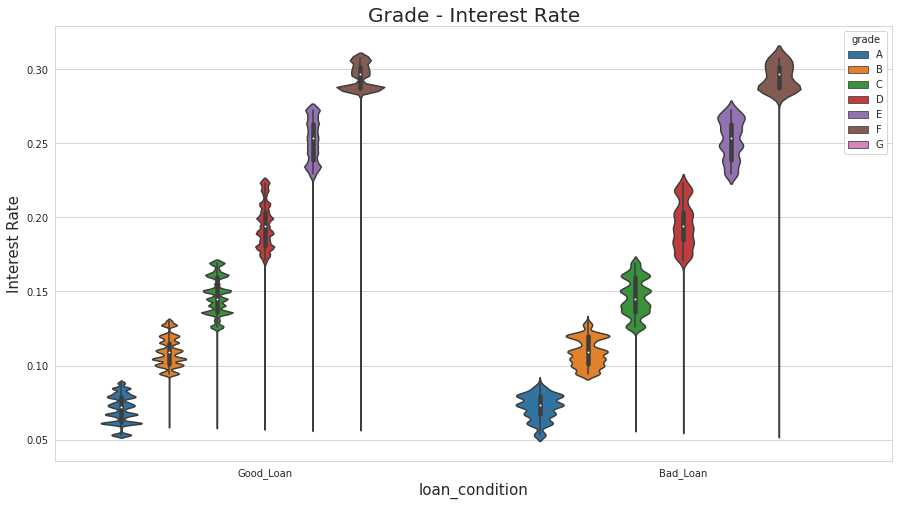

In [17]:
fig = plt.figure(figsize=(15,8))
sns.violinplot(x="loan_condition",y="int_rate",data=df0[df0['grade'] != 'G'], 
               hue="grade",hue_order=['A','B','C','D','E','F','G'])
plt.title("Grade - Interest Rate", fontsize=20)
plt.xlabel("loan_condition", fontsize=15)
plt.ylabel("Interest Rate", fontsize=15)
plt.show()

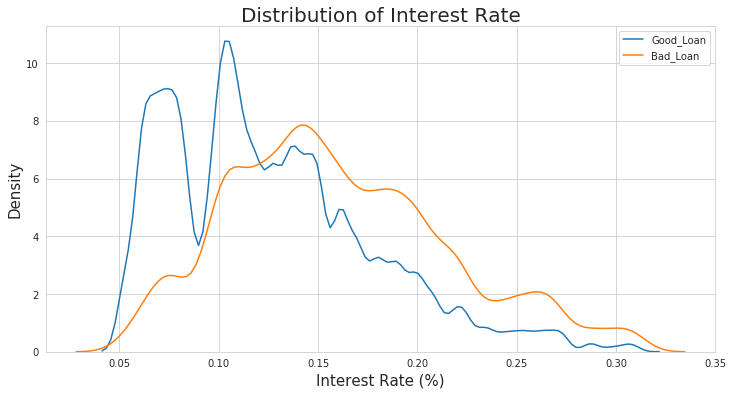

In [16]:
fig = plt.figure(figsize=(12,6))
sns.kdeplot(df0.loc[df0['loan_condition'] == 'Good_Loan', 'int_rate'], label = 'Good_Loan')
sns.kdeplot(df0.loc[df0['loan_condition'] == 'Bad_Loan', 'int_rate'], label = 'Bad_Loan');
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20)
plt.show()

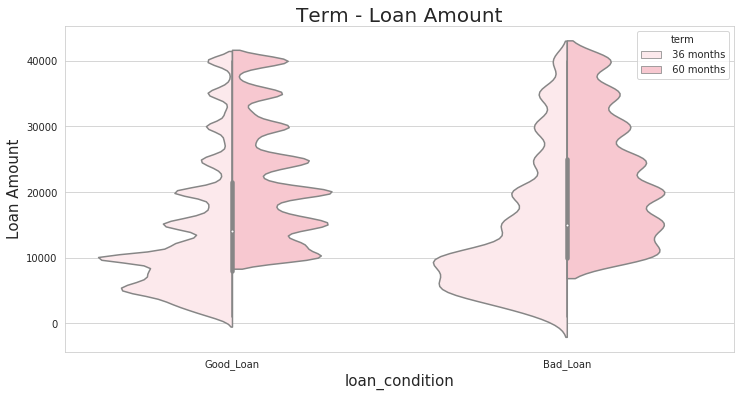

In [13]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="loan_condition",y="loan_amnt",data=df0, hue="term", split=True,color='pink')
plt.title("Term - Loan Amount", fontsize=20)
plt.xlabel("loan_condition", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15)
plt.show()

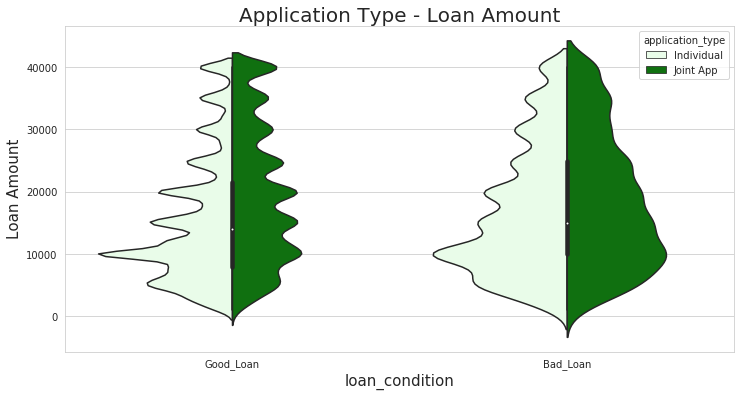

In [14]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="loan_condition",y="loan_amnt",data=df0, hue="application_type", split=True,color='green')
plt.title("Application Type - Loan Amount", fontsize=20)
plt.xlabel("loan_condition", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15)
plt.show()

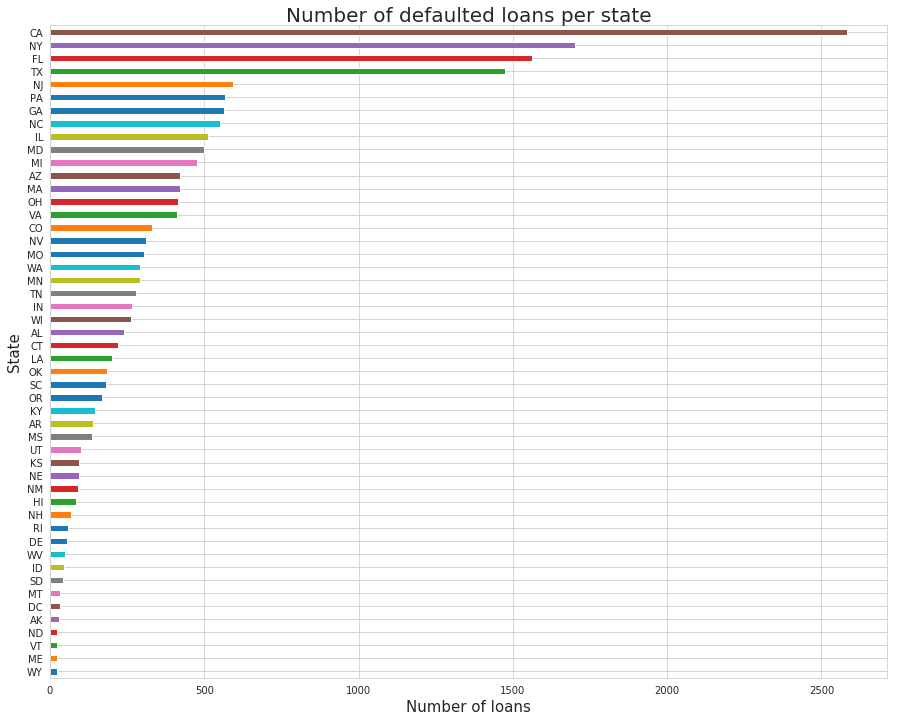

In [19]:
fig = plt.figure(figsize=(15,12))
df0[df0['loan_condition']=='Bad_Loan'].groupby('addr_state')['loan_condition'].count().sort_values().plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20)
plt.show()

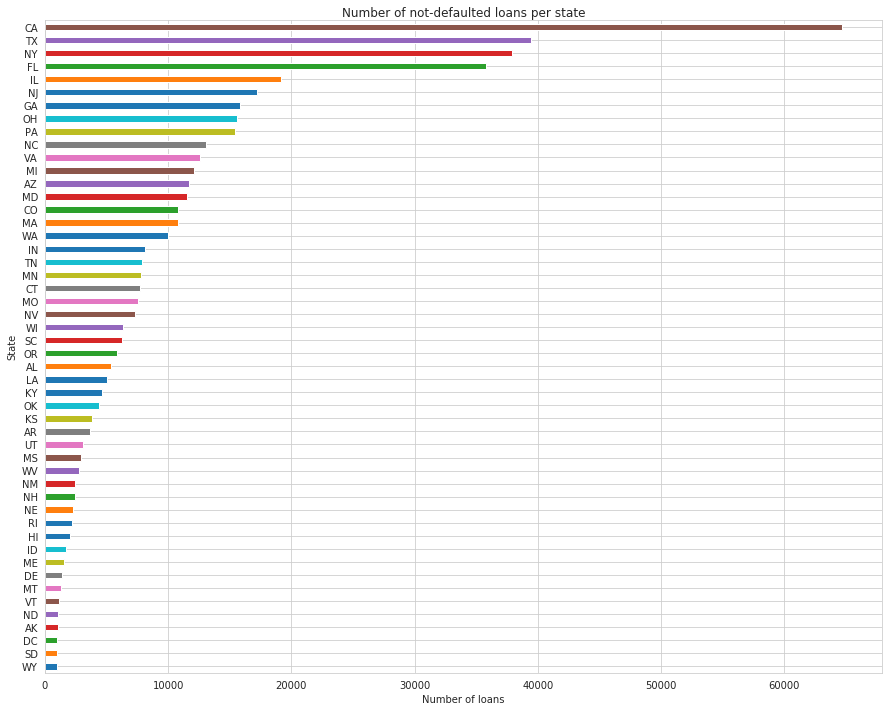

In [18]:
fig = plt.figure(figsize=(15,12))
df0[df0['loan_condition']=='Good_Loan'].groupby('addr_state')['loan_condition'].count().sort_values().plot(kind='barh')
plt.ylabel('State')
plt.xlabel('Number of loans')
plt.title('Number of not-defaulted loans per state')
plt.show()

/home/glm2class2019/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/glm2class2019/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


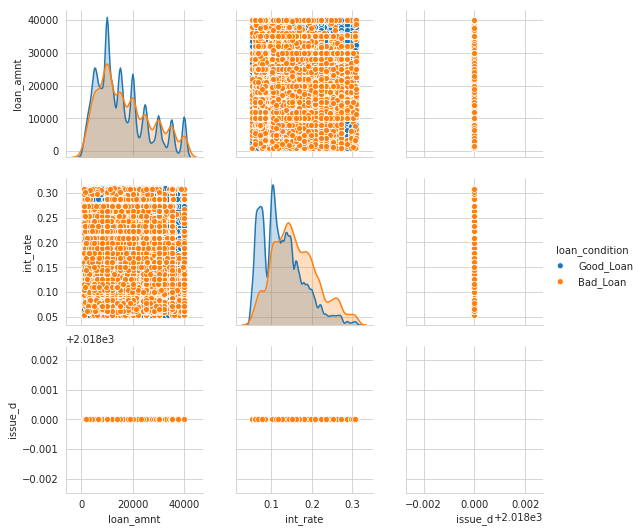

In [17]:
eda_cols = ['loan_amnt', 'term', 'int_rate', 'grade', 'issue_d', 'loan_condition']

sns.pairplot(df0[eda_cols], kind="scatter", hue='loan_condition')
plt.show()

# Feature Engineering

## Variable Selection

In [132]:
feature_col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
               'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership',
               'annual_inc', 'verification_status', 'issue_d','pymnt_plan',
               'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
               #'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
               'open_acc', 'pub_rec', 'revol_bal',
               'revol_util', 'total_acc', 'loan_condition']

df0 = df0[feature_col]

## More EDA (Boxplots on selected variables)

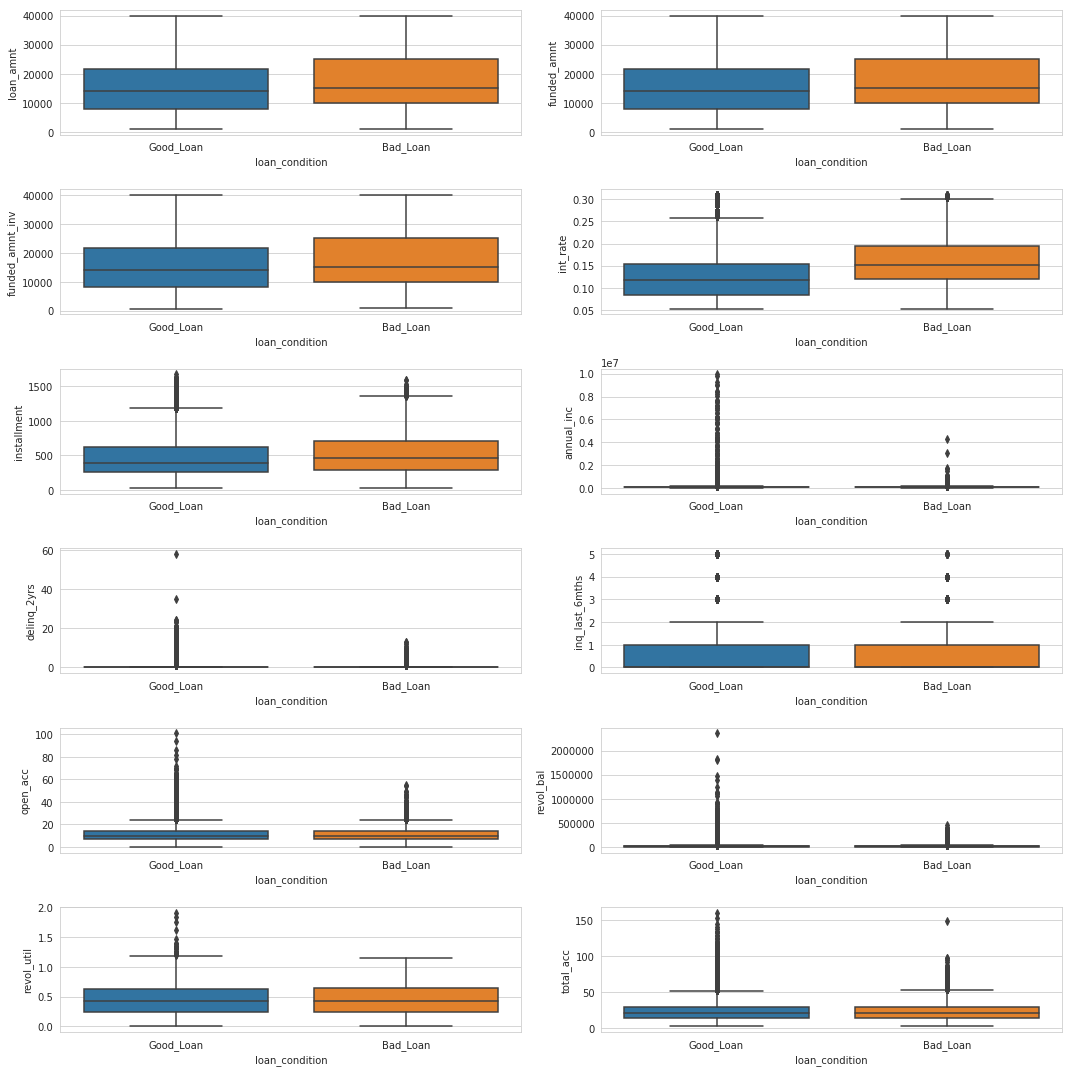

In [133]:
## Generating 3*4 matrix of box plots
fig, axes = plt.subplots(6, 2, figsize = (15,15))
axes = axes.flatten()

j = 0
for i in [0,1,2,4,5,9,16,17,18,20,21,22]:
    sns.boxplot(x="loan_condition", y=df0.iloc[:,i], data=df0, orient='v', ax=axes[j])
    j = j+1

plt.tight_layout()
plt.show()

# Data Clean (2nd Clean - Categorical Variables)

In [19]:
## Label Encoding (Yes/No)
count = 0
for col in df0:
    if df0[col].dtype == 'object':
        if len(list(df0[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df0[col] = le.fit_transform(df0[col])
            count += 1
            print (col + " : label encoding done!")
        elif len(list(df0[col].unique())) >= 10:
            print (col + " : has more than 10 unique values!")
            print (len(list(df0[col].unique())))
            
print('%d columns were label encoded.' % count)

## One Hot Encoding
#df.drop(['emp_title','title','zip_code','desc'],axis=1,inplace=True)

term : label encoding done!
sub_grade : has more than 10 unique values!
35
pymnt_plan : label encoding done!
purpose : has more than 10 unique values!
13
addr_state : has more than 10 unique values!
50
loan_condition : label encoding done!
3 columns were label encoded.


In [20]:
# Convert the rest of the object parameters to dummy variables
df0 = pd.get_dummies(df0)

# dropping all remaining null values
df0.dropna(inplace=True)

In [22]:
df0.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,issue_d,pymnt_plan,dti,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,30000.0,30000.0,30000.0,0,0.0734,930.99,95000.0,2018,0,16.18,...,0,0,1,0,0,0,0,0,0,0
1,34825.0,34825.0,34825.0,1,0.1261,785.45,125000.0,2018,0,21.31,...,0,0,0,0,0,0,0,0,0,0
2,2600.0,2600.0,2600.0,0,0.0796,81.43,62000.0,2018,0,19.61,...,0,0,0,0,0,0,0,0,0,0
3,20000.0,20000.0,20000.0,1,0.0992,424.16,110000.0,2018,0,10.56,...,0,0,0,0,1,0,0,0,0,0
4,17000.0,17000.0,17000.0,1,0.2039,454.10,52000.0,2018,0,15.65,...,0,0,0,0,0,0,0,0,0,0


# Train-Validation-Test Split

In [23]:
# Test set: 30%
# Train set: 49%
# Validation set: 21%

## Split out Test set
X_train0, X_test, y_train0, y_test = train_test_split(df0.drop('loan_condition',axis=1),
                                        df0['loan_condition'], test_size=0.3, random_state=seed)

## Merge df back for easy processing
df = pd.concat([X_train0, y_train0], axis=1, join_axes=[X_train0.index])

## Split Train & Validation
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train0, test_size=0.3, random_state=seed+1)


# Pre-Modeling

## Custom Function

In [24]:
# Create Classification Report function

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.6f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("recall score: {0:.6f}\n".format(recall_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print("Average Accuracy: \t {0:.6f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.6f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.6f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("recall score: {0:.6f}\n".format(recall_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))
        

# Create ROC Curve plotter

def print_roc(model, X, Y):
    probs = model.predict_proba(X)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(Y, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

## Normalization, SMOTE Oversampling, NearMiss Downsampling

### Normalization

In [25]:
# Standardizing features by removing the mean and scaling to unit variance

sc = StandardScaler()
X_train0 = sc.fit_transform(X_train0)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

Normalization is a technique often applied as part of data preparation for machine learning.

Urvashi Jaitley in her blog “Why Data Normalization is necessary for Machine Learning models” made a good summary point on data normalization. She believed the goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. 

It makes sense for us to normalize our datasets, because some of the features have different ranges.

### Oversampling

In [26]:
# Oversampling only the training set using SMOTE

sampling_time1 = time.time()

sm = SMOTE(random_state=seed+2, n_jobs=7)
x_train0_r, y_train0_r = sm.fit_sample(X_train0, y_train0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

sampling_time2 = time.time()

np.bincount(y_train_r)

array([233224, 233224])

In [27]:
print("--- %s seconds ---" % (sampling_time2 - sampling_time1))

--- 25.7192165851593 seconds ---


### Downsampling

In [28]:
# Downsampling using NearMiss Method

sampling_time3 = time.time()

nr = NearMiss(random_state=seed-2, n_jobs=7)
x_train0_d, y_train0_d = nr.fit_sample(X_train0, y_train0)
x_train_d, y_train_d = nr.fit_sample(X_train, y_train)

sampling_time4 = time.time()

np.bincount(y_train_d)

array([8600, 8600])

In [29]:
print("--- %s seconds ---" % (sampling_time4 - sampling_time3))

--- 407.1889154911041 seconds ---


When we are dealing with imbalanced datasets, the most common methods are oversampling and downsampling. Some of the supervised learning problems will suffer from imbalanced data, therefore, it's very crucial to apply some of these methods before we build up the models. The most famous ones are SMOTE and NearMiss.

According to "SMOTE AND NEAR MISS IN PYTHON: MACHINE LEARNING IN IMBALANCED DATASETS", written by Saeed Abdul Rahim, SMOTE is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

On the other hand, NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to minority class.

We will analyze these two methods in later sections.

# Modeling

## Logistic Regression

### Comparing SMOTE vs. NearMiss

In [30]:
# Creating a baseline for accuracy and recall using Logistic regression
# Also calculate execution time

log_reg_time1 = time.time()

log_reg_r = LogisticRegression(C = 0.001,random_state=seed+3)
log_reg_r.fit(x_train_r, y_train_r)

log_reg_time2 = time.time()

In [31]:
print_score(log_reg_r, 0, 0, X_val, y_val, train=False)

Test Result:

accuracy score: 0.647260

recall score: 0.644764

Classification Report: 
              precision    recall  f1-score   support

          0       0.07      0.71      0.13      3757
          1       0.98      0.64      0.78     99883

avg / total       0.95      0.65      0.76    103640


Confusion Matrix: 
 [[ 2681  1076]
 [35482 64401]]



In [32]:
print("--- %s seconds ---" % (log_reg_time2 - log_reg_time1))

--- 30.817432403564453 seconds ---


In [33]:
# Creating a baseline for accuracy and recall using Logistic regression
# Also calculate execution time

log_reg_time3 = time.time()

log_reg_d = LogisticRegression(C = 0.001,random_state=seed+3)
log_reg_d.fit(x_train_d, y_train_d)

log_reg_time4 = time.time()

In [34]:
print_score(log_reg_d, 0, 0, X_val, y_val, train=False)

Test Result:

accuracy score: 0.347192

recall score: 0.330627

Classification Report: 
              precision    recall  f1-score   support

          0       0.04      0.79      0.08      3757
          1       0.98      0.33      0.49     99883

avg / total       0.94      0.35      0.48    103640


Confusion Matrix: 
 [[ 2959   798]
 [66859 33024]]



In [35]:
print("--- %s seconds ---" % (log_reg_time4 - log_reg_time3))

--- 0.3795938491821289 seconds ---


Looking at the comparison between the results from SMOTE and NearMiss, despite the fact that the overall processing time using NearMiss method is much shorter than that for using SMOTE method, both the accuracy and recall score using SMOTE method are much higher. This is not surprising because we lost many useful data during downsampling process.

Therefore, I would like to proceed with SMOTE method in later sections.

### Logistic Regression (With Cross Validation)

In [36]:
# Set up parameters

penalty = ['l1','l2']
C = [0.005,0.001,0.05,0.01,0.5,0.1]
random_state=[seed+10]
lr_para = dict(penalty=penalty,C=C,random_state=random_state)

In [37]:
# Grid Search CV

log_reg_cv = GridSearchCV(LogisticRegression(), lr_para, n_jobs=num_core-1)
log_reg_cv.fit(x_train0_r, y_train0_r)

print("tuned hyperparameters: (best parameters) \n", log_reg_cv.best_params_)

tuned hyperparameters: (best parameters) 
 {'random_state': 2029, 'penalty': 'l1', 'C': 0.5}


In [38]:
# Building Model

log_reg_time5 = time.time()

log_reg_best = LogisticRegression(penalty='l1', C=0.5, random_state=seed-10)
log_reg_best.fit(x_train0_r, y_train0_r)

log_reg_time6 = time.time()

In [39]:
print_score(log_reg_best, x_train0_r, y_train0_r, 0, 0, train=True)

Train Result:

accuracy score: 0.711348

recall score: 0.687161

Classification Report: 
              precision    recall  f1-score   support

          0       0.70      0.74      0.72    333107
          1       0.72      0.69      0.70    333107

avg / total       0.71      0.71      0.71    666214


Confusion Matrix: 
 [[245012  88095]
 [104209 228898]]

Average Accuracy: 	 0.711216
Accuracy SD: 		 0.001293


In [40]:
print("--- %s seconds ---" % (log_reg_time6 - log_reg_time5))

--- 1298.6267139911652 seconds ---


## Random Forest

### Random Forest (No Tuning)

In [41]:
# Creating RF Model
# Also calculate execution time

clf_rf_time1 = time.time()

clf_rf = RandomForestClassifier(n_estimators=100, 
                                n_jobs=7, random_state=seed+4)
clf_rf.fit(x_train_r, y_train_r)

clf_rf_time2 = time.time()

In [42]:
print_score(clf_rf, 0, 0, X_val, y_val, train=False)

Test Result:

accuracy score: 0.963557

recall score: 0.999660

Classification Report: 
              precision    recall  f1-score   support

          0       0.29      0.00      0.01      3757
          1       0.96      1.00      0.98     99883

avg / total       0.94      0.96      0.95    103640


Confusion Matrix: 
 [[   14  3743]
 [   34 99849]]



In [43]:
print("--- %s seconds ---" % (clf_rf_time2 - clf_rf_time1))

--- 56.934871435165405 seconds ---


### Random Forest (With Cross Validation)

In [44]:
# Set up parameters

n_estimators = [150,200,250]
max_depth = [7,9,11]
min_samples_split = [2,3]
n_jobs = [num_core-1]
random_state = [seed+20]
rf_para = dict(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs,
              min_samples_split=min_samples_split, random_state=random_state)

In [45]:
# Grid Search CV

clf_rf_cv = GridSearchCV(RandomForestClassifier(), rf_para, 
                            n_jobs=num_core-1)
clf_rf_cv.fit(x_train0_r, y_train0_r)

print("tuned hyperparameters: (best parameters) \n", clf_rf_cv.best_params_)

tuned hyperparameters: (best parameters) 
 {'random_state': 2039, 'n_estimators': 250, 'max_depth': 11, 'n_jobs': 7, 'min_samples_split': 2}


In [46]:
# Building Model

clf_rf_time3 = time.time()

clf_rf_best = RandomForestClassifier(n_estimators=250, max_depth=11,
                         min_samples_split=2, n_jobs=7, random_state=seed-10)
clf_rf_best.fit(x_train0_r, y_train0_r)

clf_rf_time4 = time.time()

In [47]:
print_score(clf_rf_best, x_train0_r, y_train0_r, 0, 0, train=True)

Train Result:

accuracy score: 0.917265

recall score: 0.938188

Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.90      0.92    333107
          1       0.90      0.94      0.92    333107

avg / total       0.92      0.92      0.92    666214


Confusion Matrix: 
 [[298578  34529]
 [ 20590 312517]]

Average Accuracy: 	 0.913166
Accuracy SD: 		 0.025433


In [48]:
print("--- %s seconds ---" % (clf_rf_time4 - clf_rf_time3))

--- 157.8775873184204 seconds ---


## XGBoost

### XGBoost (No Tuning)

In [49]:
# Creating XGBoost Model
# Also calculate execution time

clf_xg_time1 = time.time()

clf_xg = xgb.XGBClassifier(objective ='binary:logistic', max_depth=5, 
                          learning_rate=0.1, n_estimators=150, 
                          n_jobs=7, random_state=seed+5)
clf_xg.fit(x_train_r, y_train_r)

clf_xg_time2 = time.time()

In [50]:
print_score(clf_xg, 0, 0, X_val, y_val, train=False)

Test Result:

accuracy score: 0.963971

recall score: 0.999990

Classification Report: 
              precision    recall  f1-score   support

          0       0.96      0.01      0.01      3757
          1       0.96      1.00      0.98     99883

avg / total       0.96      0.96      0.95    103640


Confusion Matrix: 
 [[   24  3733]
 [    1 99882]]



In [51]:
print("--- %s seconds ---" % (clf_xg_time2 - clf_xg_time1))

--- 82.51269268989563 seconds ---


### XGBoost (With Cross Validation)

In [52]:
# Set up parameters

max_depth=[5,7,9] 
learning_rate=[0.3,0.5]
n_estimators=[150,200]
n_jobs = [num_core-1]
random_state = [seed+30]
xg_para = dict(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs,
              learning_rate=learning_rate, random_state=random_state)

In [53]:
# Grid Search CV

clf_xg_cv = GridSearchCV(xgb.XGBClassifier(), xg_para, 
                            n_jobs=num_core-1)
clf_xg_cv.fit(x_train0_r, y_train0_r)

print("tuned hyperparameters: (best parameters) \n", clf_xg_cv.best_params_)

tuned hyperparameters: (best parameters) 
 {'random_state': 2049, 'learning_rate': 0.3, 'max_depth': 7, 'n_jobs': 7, 'n_estimators': 200}


In [54]:
# Building Model

clf_xg_time3 = time.time()

clf_xg_best = xgb.XGBClassifier(objective ='binary:logistic', max_depth=7, 
                          learning_rate=0.3, n_estimators=200, 
                          n_jobs=7, random_state=seed+5)
clf_xg_best.fit(x_train0_r, y_train0_r)

clf_xg_time4 = time.time()

In [55]:
print_score(clf_xg_best, x_train0_r, y_train0_r, 0, 0, train=True)

Train Result:

accuracy score: 0.982441

recall score: 0.999955

Classification Report: 
              precision    recall  f1-score   support

          0       1.00      0.96      0.98    333107
          1       0.97      1.00      0.98    333107

avg / total       0.98      0.98      0.98    666214


Confusion Matrix: 
 [[321424  11683]
 [    15 333092]]

Average Accuracy: 	 0.980807
Accuracy SD: 		 0.036781


In [89]:
print("--- %s seconds ---" % (clf_xg_time4 - clf_xg_time3))

--- 218.42041444778442 seconds ---


## Averaging Ensemble

In [85]:
# Building Model

ensemble_time1 = time.time()

ensemble_best = VotingClassifier(estimators=
                [('lr', log_reg_best),('rf', clf_rf_best),('xg', clf_xg_best)], 
                voting='soft', n_jobs=7)
ensemble_best.fit(x_train0_r, y_train0_r)

ensemble_time2 = time.time()

In [58]:
print_score(ensemble_best, x_train0_r, y_train0_r, 0, 0, train=True)

Train Result:

accuracy score: 0.943511

recall score: 0.950235

Classification Report: 
              precision    recall  f1-score   support

          0       0.95      0.94      0.94    333107
          1       0.94      0.95      0.94    333107

avg / total       0.94      0.94      0.94    666214


Confusion Matrix: 
 [[312050  21057]
 [ 16577 316530]]

Average Accuracy: 	 0.939275
Accuracy SD: 		 0.027609


In [90]:
print("--- %s seconds ---" % (ensemble_time2 - ensemble_time1))

--- 1407.9327342510223 seconds ---


## Save & Load Models (if necessary)

In [80]:
# Save Model for future use
save_option = False

if save_option == True:
    pickle.dump(log_reg_best, open('/home/glm2class2019/GLM/log_reg.sav', 'wb'))
    pickle.dump(clf_rf_best, open('/home/glm2class2019/GLM/clf_rf.sav', 'wb'))
    pickle.dump(clf_xg_best, open('/home/glm2class2019/GLM/clf_xg.sav', 'wb'))
    pickle.dump(ensemble_best, open('/home/glm2class2019/GLM/ensemble.sav', 'wb'))


In [87]:
# Load Model for future use
load_option = False

if load_option == True:
    log_reg_best = pickle.load(open('/home/glm2class2019/GLM/log_reg.sav', 'rb'))
    clf_rf_best = pickle.load(open('/home/glm2class2019/GLM/clf_rf.sav', 'rb'))
    clf_xg_best = pickle.load(open('/home/glm2class2019/GLM/clf_xg.sav', 'rb'))
    ensemble_best = pickle.load(open('/home/glm2class2019/GLM/ensemble.sav', 'rb'))


# Model Evaluation (Test Set)

## Initial Check

In [59]:
y_test.shape

(148056,)

## Normalization

In [60]:
# Standardizing features by removing the mean and scaling to unit variance
X_test = sc.transform(X_test)

## Prediction

### Logistic Regression

In [61]:
print_score(log_reg_best, 0, 0, X_test, y_test, train=False)

Test Result:

accuracy score: 0.688881

recall score: 0.688368

Classification Report: 
              precision    recall  f1-score   support

          0       0.08      0.70      0.14      5256
          1       0.98      0.69      0.81    142800

avg / total       0.95      0.69      0.79    148056


Confusion Matrix: 
 [[ 3694  1562]
 [44501 98299]]



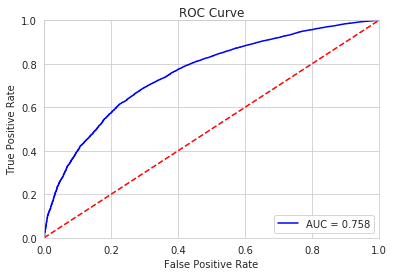

In [62]:
print_roc(log_reg_best, X_test, y_test)

### Random Forest

In [63]:
print_score(clf_rf_best, 0, 0, X_test, y_test, train=False)

Test Result:

accuracy score: 0.909683

recall score: 0.936639

Classification Report: 
              precision    recall  f1-score   support

          0       0.09      0.18      0.12      5256
          1       0.97      0.94      0.95    142800

avg / total       0.94      0.91      0.92    148056


Confusion Matrix: 
 [[   932   4324]
 [  9048 133752]]



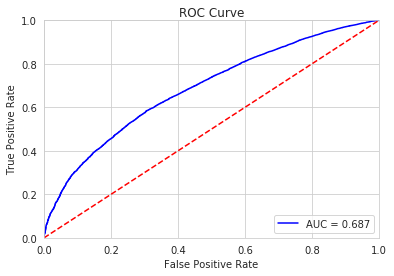

In [64]:
print_roc(clf_rf_best, X_test, y_test)

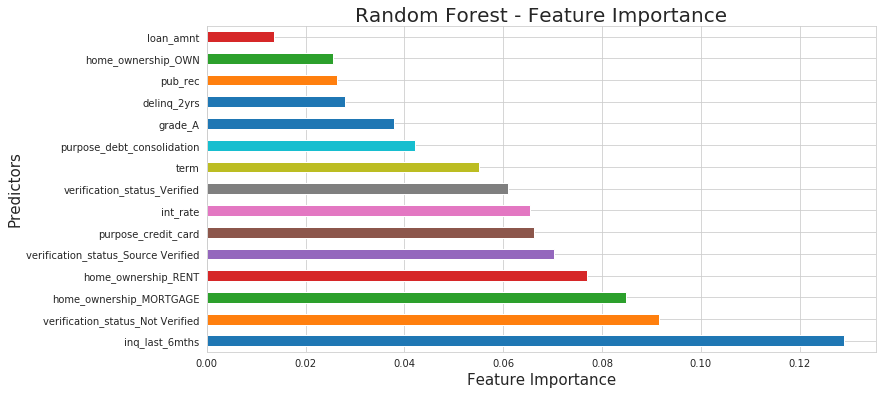

In [65]:
rf_feat = pd.Series(clf_rf_best.feature_importances_, 
                    index=df.drop('loan_condition',axis=1).columns)

fig = plt.figure(figsize=(12,6))
rf_feat.nlargest(15).plot(kind='barh')
plt.title("Random Forest - Feature Importance", fontsize=20)
plt.xlabel("Feature Importance", fontsize=15)
plt.ylabel("Predictors", fontsize=15)
plt.show()

### XGBoost

In [66]:
print_score(clf_xg_best, 0, 0, X_test, y_test, train=False)

Test Result:

accuracy score: 0.964385

recall score: 0.999559

Classification Report: 
              precision    recall  f1-score   support

          0       0.42      0.01      0.02      5256
          1       0.96      1.00      0.98    142800

avg / total       0.95      0.96      0.95    148056


Confusion Matrix: 
 [[    46   5210]
 [    63 142737]]



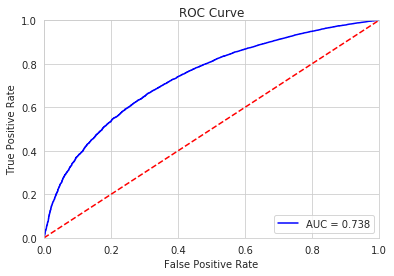

In [67]:
print_roc(clf_xg_best, X_test, y_test)

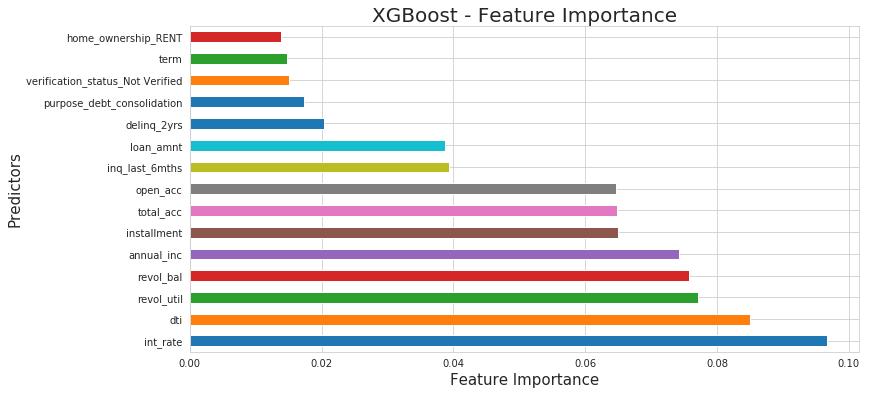

In [68]:
xg_feat = pd.Series(clf_xg_best.feature_importances_, 
                    index=df.drop('loan_condition',axis=1).columns)

fig = plt.figure(figsize=(12,6))
xg_feat.nlargest(15).plot(kind='barh')
plt.title("XGBoost - Feature Importance", fontsize=20)
plt.xlabel("Feature Importance", fontsize=15)
plt.ylabel("Predictors", fontsize=15)
plt.show()

### Averaging Ensemble

In [72]:
print_score(ensemble_best, 0, 0, X_test, y_test, train=False)

Test Result:

accuracy score: 0.951019

recall score: 0.982066

Classification Report: 
              precision    recall  f1-score   support

          0       0.18      0.11      0.13      5256
          1       0.97      0.98      0.97    142800

avg / total       0.94      0.95      0.94    148056


Confusion Matrix: 
 [[   565   4691]
 [  2561 140239]]



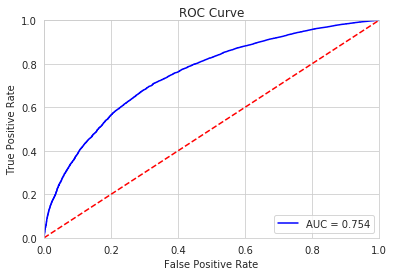

In [73]:
print_roc(ensemble_best, X_test, y_test)

## Comparison

In [91]:
ML_columns = []
ML_compare = pd.DataFrame(columns = ML_columns)

# Logisitic Regression
ML_compare.loc[0,'ML Name'] = 'Logistic Regression'
ML_compare.loc[0, 'Train Accuracy'] = 0.711348
ML_compare.loc[0, 'Test Accuracy'] = 0.688881
ML_compare.loc[0, 'Train Recall'] = 0.687161
ML_compare.loc[0, 'Test Recall'] = 0.688368
ML_compare.loc[0, 'Test AUC'] = 0.758
ML_compare.loc[0, 'Model Fit Time (sec)'] = 1298.627

# Random Forest
ML_compare.loc[1,'ML Name'] = 'Random Forest'
ML_compare.loc[1, 'Train Accuracy'] = 0.917265
ML_compare.loc[1, 'Test Accuracy'] = 0.909683
ML_compare.loc[1, 'Train Recall'] = 0.938188
ML_compare.loc[1, 'Test Recall'] = 0.936639
ML_compare.loc[1, 'Test AUC'] = 0.687
ML_compare.loc[1, 'Model Fit Time (sec)'] = 157.878

# XGBoost
ML_compare.loc[2,'ML Name'] = 'XGBoost'
ML_compare.loc[2, 'Train Accuracy'] = 0.982441
ML_compare.loc[2, 'Test Accuracy'] = 0.964385
ML_compare.loc[2, 'Train Recall'] = 0.999955
ML_compare.loc[2, 'Test Recall'] = 0.999559
ML_compare.loc[2, 'Test AUC'] = 0.738
ML_compare.loc[2, 'Model Fit Time (sec)'] = 218.420

# Averaging Ensemble
ML_compare.loc[3,'ML Name'] = 'Averaging Ensemble'
ML_compare.loc[3, 'Train Accuracy'] = 0.943511
ML_compare.loc[3, 'Test Accuracy'] = 0.951019
ML_compare.loc[3, 'Train Recall'] = 0.950235
ML_compare.loc[3, 'Test Recall'] = 0.982066
ML_compare.loc[3, 'Test AUC'] = 0.754
ML_compare.loc[3, 'Model Fit Time (sec)'] = 1407.933


In [92]:
ML_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
ML_compare

,ML Name,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Test AUC,Model Fit Time (sec)
2,XGBoost,0.982441,0.964385,0.999955,0.999559,0.738,218.420
3,Averaging Ensemble,0.943511,0.951019,0.950235,0.982066,0.754,1407.933
1,Random Forest,0.917265,0.909683,0.938188,0.936639,0.687,157.878
0,Logistic Regression,0.711348,0.688881,0.687161,0.688368,0.758,1298.627


# Reference

1. https://www.lendingclub.com/info/download-data.action
2. https://www.kaggle.com/janiobachmann/lending-club-risk-analysis-and-metrics
3. https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data#Modeling
4. https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html#svm
5. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
7. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
8. https://xgboost.readthedocs.io/en/latest/python/python_api.html
9. https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a79
10. https://towardsdatascience.com/running-jupyter-notebook-in-google-cloud-platform-in-15-min-61e16da34d52
11. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
12. https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
13. https://dzone.com/articles/installing-latex-ubuntu
14. http://www.markus-beuckelmann.de/blog/customizing-nbconvert-pdf.html
15. https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029
16. https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7